In [1]:
using MNIST
trainX, trainY = traindata()
trainX = (trainX - mean(trainX))/var(trainX); #normalise

784x60000 Array{Float64,2}:
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757  …  -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
 -0.00539757  -0.00539757  -0.00539757     -0.00539757  -0.00539757
  ⋮                                     ⋱                          
 -0.00539757  -0.005

In [2]:
#params
d = 784
n = 32
N = 60000

T = 100
t = linspace(0,1300,T);

#need to get proper data... (note that this data is normalized)
data = trainX#randn((d,N));
Y = trainX#randn((d,N)); 


#which modes are we watching?
indexs = [1, 2, 3, 5, 12, 18, 31];

In [3]:
### Whiten the data -- i dont think this is working?!?
#Decorrelate with PCA
Ux, Sx, Vx = svd(data)
println(size(Ux),size(Sx),size(Vx))
X = transpose(Ux)*data
print(size(X))

(784,784)(784,)(60000,784)
(784,60000)

In [4]:
### SVD decomposition of covar(Y,X) -- covar also needs normalising?
Uyx,Syx,Vyx = svd(Y*transpose(X))
println(size(Uyx),size(Syx),size(Vyx))
Syx = Syx/sqrt(N)

(784,784)(784,)(784,784)


784-element Array{Float64,1}:
 9.88505    
 2.01154    
 1.56382    
 1.35014    
 1.1614     
 0.950437   
 0.802912   
 0.640751   
 0.627811   
 0.522522   
 0.466126   
 0.454961   
 0.412286   
 ⋮          
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 9.87715e-16
 8.95733e-16

In [5]:
### Initialize orthonormal weight matrices
#svd of some random matrix
#pick subset of n rows of U
R = svd(randn((784,784)))[1][1:n,:]

#???
D_a = diagm(randn(784))
D_b = diagm(randn(784))

#eqns from saxe
A = Uyx*D_a*transpose(R) #dxn
B = R*D_b*Vyx; #nxd
println(size(A),size(B))

(784,32)(32,784)


In [6]:
### now let's train it
#params
η = 0.1e-3;

In [7]:
### Linear NN
LinearLoss(A,B,x) = ((norm(x-A*B*x))^2)/N
dLdA(A,B,x) =  transpose(-2*B*x*transpose(x) + B*x*transpose(x)*transpose(B)*transpose(A))
dLdB(A,B,x) =  transpose(-2*x*transpose(x)*A + x*transpose(x)*transpose(B)*transpose(A)*A)

println("Loss = ",LinearLoss(A,B,X))
dA = dLdA(A,B,X)
dB = dLdB(A,B,X)
print("dA: ",size(dA),"  dB: ",size(dB))

Loss = 0.0404107602680976
dA: (784,32)  dB: (32,784)

In [8]:
#function trainer(dLdA,dLdB)
modes = zeros((n,T))
for i in 1:T
    W = A*B
    U,S,V = svd(W)
    modes[1:n,i] = S[1:n]

    #grad descent -- am i supposed to be doing this with batches?
    A -= η*dLdA(A,B,X)
    B -= η*dLdB(A,B,X)
end
#    return modes
#end

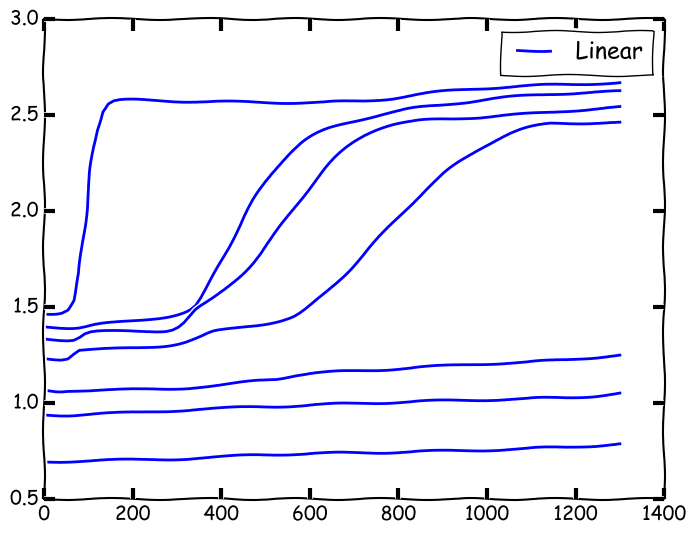

PyObject <matplotlib.legend.Legend object at 0x31d3ca2e8>

In [9]:
using PyPlot
xkcd();

#modes = trainer(dLdA,dLdB)
for i in indexs
    plot(t,reshape(modes[i,:],T),c="blue")
end
legend(["Linear"])

In [22]:
### Non-linear -- Rectifier
function reluLoss(A,B,x) 
    z1 = B*x
    z2 = A * (z1 .* (z1 .> 0))#relu
    return sum((x - z2 .* (z2 .> 0)).^2)
end

#relu(x) = x .* (x .>0)
#sum((x - relu(A * relu(B*x)) ).^2)
#L = reluLoss(A,B,X,Y)

using ReverseDiffSource
#ahh. doesnt work with norms
#doesnt work with logic functions
#maybe max works?

input = X[:,1]
grads = rdiff(reluLoss, (A,B,input), ignore=[:input]);

LoadError: LoadError: no derivation rule for .> at arg #1
while loading In[22], in expression starting on line 18

In [14]:
# Softplus
softplus(x)=log(1+e.^(x))
function NonLinLoss(A,B,x,fn)
    return sum((x - fn(A*fn(B*x))).^2)
end




# ELU



# Maxout (?)

NonLinLoss (generic function with 1 method)

In [24]:
grads = rdiff(NonLinLoss, (A,B,input,softplus), ignore=[:input,:softplus]);

LoadError: LoadError: MethodError(call,(:fn,[0.04606315595842404,0.04114971419277253,0.05785293631372832,-0.09607379423059507,-0.06408340937938664,0.0430402495788064,-0.005891358516713725,-0.007958371855176895,0.05189317021487609,-0.07061167585033652,0.07474583576089114,0.08076623342347604,0.05633425465491927,-0.04291162787849074,-0.015695576996948173,0.09567707929292037,-0.026476096661717845,-0.06574764003588489,0.00287130929415488,0.006400595383875329,0.0241936394225305,-0.09467623325532683,0.1469682699363286,-0.0296411308003738,0.03793778322099598,0.007937858500034058,-0.004204031122421173,0.0351621560803498,-0.03753370459736196,-0.011325089213576639,-0.014274980895054926,-0.0589468025974277])) when calling fn([0.04606315595842404,0.04114971419277253,0.05785293631372832,-0.09607379423059507,-0.06408340937938664,0.0430402495788064,-0.005891358516713725,-0.007958371855176895,0.05189317021487609,-0.07061167585033652,0.07474583576089114,0.08076623342347604,0.05633425465491927,-0.04291162787849074,-0.015695576996948173,0.09567707929292037,-0.026476096661717845,-0.06574764003588489,0.00287130929415488,0.006400595383875329,0.0241936394225305,-0.09467623325532683,0.1469682699363286,-0.0296411308003738,0.03793778322099598,0.007937858500034058,-0.004204031122421173,0.0351621560803498,-0.03753370459736196,-0.011325089213576639,-0.014274980895054926,-0.0589468025974277]) in 
node | symbol     | ext ? | type       | parents  | precedence | main  | value                                                       | 
---- | ---------- | ----- | ---------- | -------- | ---------- | ----- | ----------------------------------------------------------- | 
1    |            |       | [constant] |          |            | sum   | (Function) sum                                              | 
2    | fn >>      |       | [external] |          |            | :fn   | (Function) softplus                                         | 
3    |            |       | [constant] |          |            | 2     | (Int64) 2                                                   | 
4    |            |       | [constant] |          |            | *     | (Function) *                                                | 
5    | B >>       |       | [external] |          |            | :B    | (Array{Float64,2}) [0.1692113874619945 0.1719216069931661 - | 
6    |            |       | [constant] |          |            | .^    | (Function) .^                                               | 
7    | A >>       |       | [external] |          |            | :A    | (Array{Float64,2}) [0.2216390929201925 -0.01410440532337108 | 
8    |            |       | [constant] |          |            | -     | (Function) -                                                | 
9    | x >>       |       | [external] |          |            | :x    | (Array{Float64,1}) [0.21717958471730037,0.00087746026527353 | 
10   |            |       | [constant] |          |            | Main  | (Module) Main                                               | 
11   |            |       | [call]     | 4, 5, 9  |            | :call | (Array{Float64,1}) [0.04606315595842404,0.04114971419277253 | 
12   |            |       | [call]     | 2, 11    |            | :call | (Float64) NaN                                               | 
13   |            |       | [call]     | 4, 7, 12 |            | :call | (Float64) NaN                                               | 
14   |            |       | [call]     | 2, 13    |            | :call | (Float64) NaN                                               | 
15   |            |       | [call]     | 8, 9, 14 |            | :call | (Float64) NaN                                               | 
16   |            |       | [call]     | 6, 15, 3 |            | :call | (Float64) NaN                                               | 
17   | nothing << |       | [call]     | 1, 16    |            | :call | (Float64) NaN                                               | 

while loading In[24], in expression starting on line 1

In [15]:
NonLinLoss(A,B,X,softplus)

2.3376900991138615e7

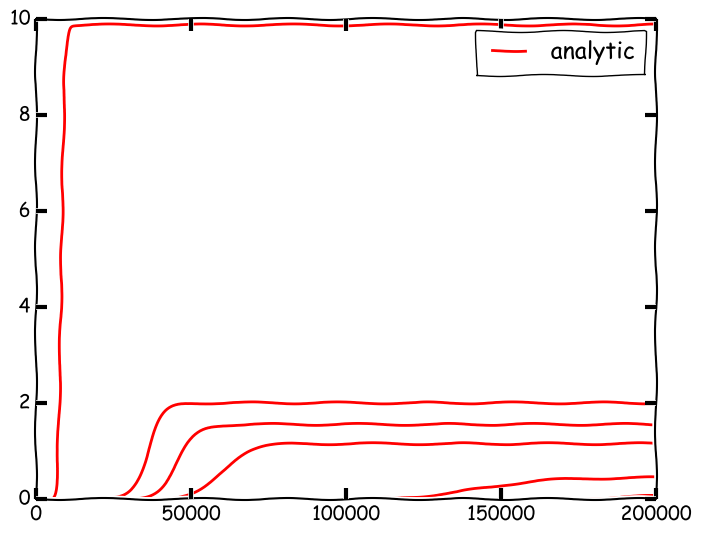

PyObject <matplotlib.legend.Legend object at 0x322f82940>

In [18]:
### Analytic
t = linspace(0,200000,1000)
f(t,tau,s,u0) = s*exp(2*s.*t/tau)./(exp(2*s.*t./tau) - 1 + s/u0)
for i in indexs
    plot(t,f(t,1/η,Syx[i],1e-6),c="red")
end
legend(["analytic"])

LoadError: LoadError: UndefVarError: autoencoderError not defined
while loading In[12], in expression starting on line 2